<a href="https://colab.research.google.com/github/DivyanshYadav12/Handwritten-text-Recognition/blob/main/Handwritten_text_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import keras
import keras.layers as L
import keras.models as M
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
from keras.utils import Sequence

In [ ]:
train=pd.read_csv('/content/written_name_train_v2.csv')
validation=pd.read_csv('/content/written_name_validation_v2.csv')

In [ ]:
train.dropna(inplace=True)

In [ ]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [ ]:
train[train['IDENTITY']=='zucchi']

,FILENAME,IDENTITY
20507,TRAIN_20508.jpg,zucchi


In [ ]:
train['Length']=train['IDENTITY'].apply(lambda x : len(str(x)))
train=train[train['Length']<=21]
train['IDENTITY']=train['IDENTITY'].str.upper()
train[train['Length']==max(train['Length'])]

,FILENAME,IDENTITY,Length
10278,TRAIN_10279.jpg,DOSSANTOS LASCONCELOS,21
108567,TRAIN_108568.jpg,O ZUARRDI EREBEVITRAC,21
156500,TRAIN_156501.jpg,ANDRIANNARISOA--DEGHI,21
160575,TRAIN_160576.jpg,LOUISIANE - EVANGELIN,21
174121,TRAIN_174122.jpg,GU ILLOSSOO - OARRIBA,21
212583,TRAIN_212584.jpg,DE MALEZIEUX DU HAMEL,21
220135,TRAIN_220136.jpg,COSTREL DE CORAINVILL,21
229529,TRAIN_229530.jpg,ROUSSEAV -- CHAUDIERE,21
230011,TRAIN_230012.jpg,BEKNARD DE LAVERNETTE,21
308769,TRAIN_308770.jpg,DATE NAISSANCE CLASSE,21


In [ ]:
train=train.sample(frac=0.8,random_state=42)
validation=validation.sample(frac=0.1)

In [ ]:
characters=set()
train['IDENTITY']=train['IDENTITY'].apply(lambda x: str(x))
for i in train['IDENTITY'].values:
    for j in i :
        if j not in characters :
            characters.add(j)
characters=sorted(characters)

In [ ]:
# 2 Dictionaries  :   Turn all ur characters to num and vice versa
char_to_label = {char:label for label,char in enumerate(characters)}
label_to_char = {label:char for label,char in enumerate(characters)}

In [ ]:
path_train='/content/train_v2/train'
path_validation='/content/validation_v2/validation'

In [ ]:
# Data Generator
class DataGenerator(Sequence):
    def __init__(self,dataframe,path,char_map,batch_size=128,img_size=(256,64),
                 downsample_factor=4,max_length=22,shuffle=True):
        self.dataframe=dataframe
        self.path=path
        self.char_map=char_map
        self.batch_size=batch_size
        self.width=img_size[0]
        self.height=img_size[1]
        self.downsample_factor=downsample_factor
        self.max_length=max_length
        self.shuffle=shuffle
        self.indices = np.arange(len(dataframe))
        self.on_epoch_end()

    def __len__(self):
        return len(self.dataframe)//self.batch_size

    def __getitem__(self,idx):
        curr_batch_idx=self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_images=np.ones((self.batch_size,self.width,self.height,1),dtype=np.float32)
        batch_labels=np.ones((self.batch_size,self.max_length),dtype=np.float32)
        input_length=np.ones((self.batch_size,1),dtype=np.float32)*(self.width//self.downsample_factor-2)
        label_length=np.zeros((self.batch_size,1),dtype=np.int64)
        for i,idx in enumerate(curr_batch_idx):
            img_path=self.dataframe['FILENAME'].values[idx]
            img=cv2.imread(self.path+'/'+img_path)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img=cv2.resize(img,(self.width,self.height))
            img=(img/255).astype(np.float32)
            img=img.T
            img=np.expand_dims(img,axis=-1)
            text=self.dataframe['IDENTITY'].values[idx]
            text=str(text)
            label=[]
            for j in text:
                if j in self.char_map :
                    label.append(self.char_map[j])
                else:
                    label.append(100)
            label.extend([100]*(22-len(label)))
            batch_images[i]=img
            batch_labels[i]=label
            label_length[i]=len(label)
        batch_inputs= {
                'input_data':batch_images,
                'input_label':batch_labels,
                'input_length':input_length,
                'label_length':label_length

            }
        return batch_inputs,np.zeros((self.batch_size),dtype=np.float32)
    def on_epoch_end(self):
        if self.shuffle == True :
            np.random.shuffle(self.indices)


In [ ]:
train_generator=DataGenerator(train,path_train,char_to_label)
validation_generator=DataGenerator(validation,path_validation,char_to_label)

In [ ]:
# Making CTC Function
class CTCLayer(L.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # On test time, just return the computed loss
        return loss

In [ ]:
# Making the Model now
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
# Import Model as M
from tensorflow.keras import Model as M
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2

def make_model():
    class CustomCTCLoss(Layer):  # Renamed to avoid conflicts
        def __init__(self, name=None):
            super().__init__(name=name)
            # Changed to import from correct location
            self.loss_fn = tf.keras.losses.CTCLoss()

        def call(self, y_true, y_pred, input_length, label_length):
            return self.loss_fn(y_true, y_pred, input_length, label_length)
    inp=L.Input(shape=(256,64,1),dtype=np.float32,name='input_data')
    labels=L.Input(shape=[22],dtype=np.float32,name='input_label')
    input_length=L.Input(shape=[1],dtype=np.int64,name='input_length')
    label_length=L.Input(shape=[1],dtype=np.int64,name='label_length')
    x=L.Conv2D(64,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(inp)
    x=L.MaxPooling2D(pool_size=(2,2))(x)
    x=L.Dropout(0.3)(x)
    x=L.Conv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(x)
    x=L.MaxPooling2D(pool_size=(2,2))(x)
    x=L.Dropout(0.3)(x)
    new_shape=((256//4),(64//4)*128)
    x=L.Reshape(new_shape)(x)
    x=L.Dense(64,activation='relu')(x)
    x=L.Dropout(0.2)(x)
    x=L.Bidirectional(L.LSTM(128,return_sequences=True,dropout=0.2))(x)
    x=L.Bidirectional(L.LSTM(64,return_sequences=True,dropout=0.25))(x)
    x=L.Dense(len(characters)+1,activation='softmax',kernel_initializer='he_normal',name='Dense_output')(x)
    output=CTCLayer(name='outputs')(labels,x,input_length,label_length)
    # Use M directly to create the model instance
    model=M([inp,labels,input_length,label_length],output)
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    model.compile(optimizer=sgd)
    return model

In [ ]:
model=make_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_data (InputLayer)   │ (None, 256, 64, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 64, 64)    │            640 │ input_data[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 32, 64)    │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 32, 64)    │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 32, 128)   │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 16, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 16, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 64, 2048)       │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64, 64)         │        131,136 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64, 256)        │        197,632 │ dropout_2[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 64, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_label (InputLayer)  │ (None, 22)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_output (Dense)      │ (None, 64, 31)         │          3,999 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_length (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label_length (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ outputs (CTCLayer)        │ (None, 1)              │              0 │ input_label[0][0],     │
│                           │                        │                │ Dense_output[0][0],    │
│                      

 Total params: 571,615 (2.18 MB)

 Trainable params: 571,615 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
if 'prediction_model_ocr.h5' not in os.listdir('./'):
    history = model.fit(train_generator,steps_per_epoch=1000,validation_data=validation_generator,
                        epochs=8)


Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 234s 222ms/step - loss: 3078.4031 - val_loss: 2413.1826
Epoch 2/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 221s 221ms/step - loss: 2384.2307 - val_loss: 2193.7830
Epoch 3/8
  64/1000 ━━━━━━━━━━━━━━━━━━━━ 3:20 214ms/step - loss: 2203.8792

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 2197.7043 - val_loss: 2186.3564
Epoch 4/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 255s 219ms/step - loss: 2106.4263 - val_loss: 1781.2283
Epoch 5/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 217s 217ms/step - loss: 1705.8593 - val_loss: 1213.9395
Epoch 6/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 1279.3715 - val_loss: 1172.9263
Epoch 7/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 218s 217ms/step - loss: 1165.8662 - val_loss: 776.7535
Epoch 8/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 223s 223ms/step - loss: 852.1327 - val_loss: 602.4350


In [ ]:
for layer in model.layers:
    print(layer.name)

input_data
conv2d
max_pooling2d
dropout
conv2d_1
max_pooling2d_1
dropout_1
reshape
dense
dropout_2
bidirectional
bidirectional_1
input_label
Dense_output
input_length
label_length
outputs


In [ ]:
prediction_model = keras.models.Model(
    inputs=model.input,  # Directly use the model's main input
    outputs=model.get_layer(name='Dense_output').output  # Specify the output layer
)
prediction_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_data (InputLayer)   │ (None, 256, 64, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 64, 64)    │            640 │ input_data[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 32, 64)    │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 32, 64)    │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 32, 128)   │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 16, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 16, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 64, 2048)       │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64, 64)         │        131,136 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64, 256)        │        197,632 │ dropout_2[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 64, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_label (InputLayer)  │ (None, 22)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_length (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label_length (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_output (Dense)      │ (None, 64, 31)         │          3,999 │ bidirectional_1[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 571,615 (2.18 MB)

 Trainable params: 571,615 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import load_model

# Save the model in the recommended .keras format
if 'prediction_model_ocr.keras' not in os.listdir('./'):
    prediction_model.save('prediction_model_ocr.keras')  # Save in the new format

# Load the model
prediction_model = load_model('prediction_model_ocr.keras')

In [ ]:
label_to_char[100]=''

In [ ]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]

    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred,
                                        input_length=input_len,
                                        greedy=True)[0][0]

    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += label_to_char[c]
        output_text.append(outstr)

    # return final text results
    return output_text

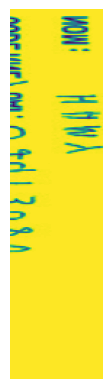

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step 
Ground truth: HAMY 	 Predicted: ANO
Ground truth: BOISSELEAU 	 Predicted: BOISSELEAU
Ground truth: GEORGE 	 Predicted: GEORGE
Ground truth: CLEMENCE 	 Predicted: CLEMGNCE
Ground truth: LALY 	 Predicted: LAEY
Ground truth: HARIE 	 Predicted: MARIE
Ground truth: MORIZOT 	 Predicted: MORIEOT
Ground truth: ENZO 	 Predicted: EHIS
Ground truth: KENZO 	 Predicted: VENCO
Ground truth: ZEDDA 	 Predicted: LEDOA
Ground truth: COUGE 	 Predicted: COUSE
Ground truth: MOREIRA 	 Predicted: MOBEIRA
Ground truth: ALEXIS 	 Predicted: ALEXIS
Ground truth: LEOPOLD 	 Predicted: LESOLA
Ground truth: MORIN 	 Predicted: MORIN
Ground truth: ROBIN 	 Predicted: RODIN
Ground truth: ANTHONY 	 Predicted: ANTHOND
Ground truth: IMESSTI 	 Predicted: CHESSTI
Ground truth: CORENTIN 	 Predicted: CORENTIN
Ground truth: SALERNO 	 Predicted: SALEANO
Ground truth: BRANCHARD 	 Predicted: BRAMCHAAD
Ground truth: GROSJEANNE 	 Predicted: GAOESEAUI
Ground truth: EMILIE 	 Predicted: EHILIE
Gro

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for p, (inp_value, _) in enumerate(validation_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']

    # Assuming `input_length` and `label_length` are part of `inp_value`
    input_length = inp_value.get('input_length')
    if input_length is None or (isinstance(input_length, np.ndarray) and input_length.size == 0):
        input_length = np.ones((bs, 1)) * 64  # Adjust as needed

    label_length = inp_value.get('label_length')
    if label_length is None or (isinstance(label_length, np.ndarray) and label_length.size == 0):
        label_length = np.ones((bs, 1)) * 22  # Adjust as needed

    # Display the first image in the batch
    plt.imshow(X_data[0])
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

    # Make predictions with all required inputs
    preds = prediction_model.predict([X_data, labels, input_length, label_length])
    pred_texts = decode_batch_predictions(preds)

    # Decode the ground truth labels
    orig_texts = []
    for label in labels:
        text = ''.join([label_to_char[int(x)] for x in label])
        orig_texts.append(text)

    # Print ground truth and predictions
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')

    # Break after the first batch for testing
    break


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


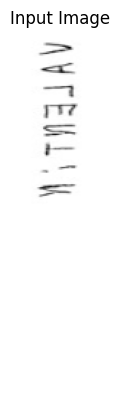

Predicted Text: VALENTIN


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize a batch of images
batch_size = 128
batch_images = np.ones((batch_size, 256, 64, 1), dtype=np.float32)

# Load the image
img_path = '/content/test_v2/test/TEST_34080.jpg'
img = cv2.imread(img_path)

if img is None:
    print("Failed to load image. Check the file path.")
else:
    # Preprocess the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, (256, 64))  # Resize to the expected dimensions
    img = (img / 255).astype(np.float32)  # Normalize the image

    # Transpose and expand dimensions
    img = img.T  # Transpose to match model input shape
    img = np.expand_dims(img, axis=-1)  # Add channel dimension

    # Add the preprocessed image to the batch
    batch_images[0] = img

    # Create dummy inputs for prediction
    dummy_labels = np.zeros((batch_size, 22))  # Dummy labels of shape (batch_size, 22)
    input_length = np.ones((batch_size, 1)) * 64  # Assuming 64 is the input length
    label_length = np.ones((batch_size, 1)) * 22  # Assuming 22 is the label length

    # Make predictions
    x = prediction_model.predict([batch_images, dummy_labels, input_length, label_length])
    pred_texts = decode_batch_predictions(x)
    pred_texts = pred_texts[0]  # Get the prediction for the first image

    # Display the preprocessed image
    plt.imshow(img.squeeze(), cmap='gray')  # Show the image in grayscale
    plt.axis('off')  # Hide axes for better visualization
    plt.title('Input Image')
    plt.show()

    print('Predicted Text:', pred_texts)


